In [29]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import pickle
import json
from PIL import Image
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, '..')
from utils import load_captions_txt # Importa la tua funzione

# --- CARICA LE RISORSE SALVATE ---

# 1. Carica il modello addestrato
print("Caricamento del modello...")
model = load_model('models/model_caption_finetuned.keras')

# 2. Carica il tokenizer
# Percorso relativo: "vai su ('..') e troverai il file lì"
print("Caricamento del tokenizer...")
with open('tokenizer.json', 'r') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)

# 3. Carica le feature delle immagini
# Percorso relativo: "cerca la cartella 'features' nella directory corrente"
# Questo era già corretto.
print("Caricamento delle feature delle immagini...")
with open("features/image_features.pkl", "rb") as f:
    image_features = pickle.load(f)
    
# 4. Carica le caption originali (già corretto)
captions_dict = load_captions_txt("../data/Flickr8k_text/captions.txt")

# 5. Definisci le costanti (questo rimane uguale)
max_length = 40 # Sostituisci con la tua max_length esatta!
vocab_size = len(tokenizer.word_index) + 1

print("\n✔️ Setup completato.")

Caricamento del modello...
Caricamento del tokenizer...
Caricamento delle feature delle immagini...

✔️ Setup completato.


In [30]:
def generate_caption(model, tokenizer, feature_vector, max_length):
    """
    Genera una caption per un'immagine dato il suo vettore di feature.
    """
    # Il vettore delle feature deve essere preparato per il modello
    feature_vector = np.reshape(feature_vector, (1, 2048))
    
    # Iniziamo la sequenza con il token 'startseq'
    in_text = 'startseq'
    
    # Itera per generare la sequenza, parola per parola
    for i in range(max_length):
        # Converti la sequenza attuale in interi
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # Aggiungi padding per raggiungere la max_length
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Fai la predizione con il modello
        # L'output è una distribuzione di probabilità su tutto il vocabolario
        yhat = model.predict([feature_vector, sequence], verbose=0)
        
        # Trova l'indice della parola con la probabilità più alta (greedy search)
        best_word_index = np.argmax(yhat)
        
        # Converti l'indice in parola
        word = tokenizer.index_word.get(best_word_index)
        
        # Se non trova la parola (improbabile), esci
        if word is None:
            break
            
        # Aggiungi la parola predetta alla sequenza
        in_text += ' ' + word
        
        # Se la parola predetta è 'endseq', abbiamo finito
        if word == 'endseq':
            break
            
    # Pulisci la sequenza finale
    final_caption = in_text.split()
    final_caption = final_caption[1:-1] # Rimuovi 'startseq' e 'endseq'
    final_caption = ' '.join(final_caption)
    
    return final_caption

print("Funzione 'generate_caption' definita.")

Funzione 'generate_caption' definita.


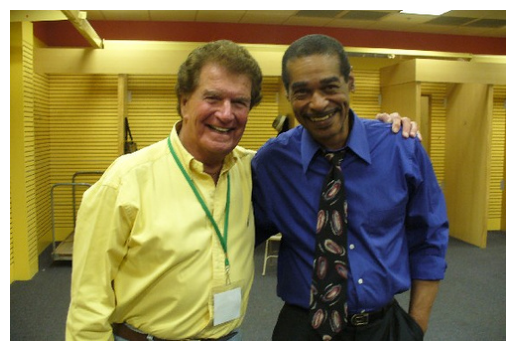

--- RISULTATI ---
Caption Generata: a man in a black shirt is standing in a camera

Caption Reali:
- a man in a yellow and yellow shirt puts his arm around a man in a blue shirt
- a man in a yellow shirt and a man in a blue shirt and tie posing for a picture
- two employees pose for a picture
- "two guys , one black and one white , smiling for the camera ."
- two men each have one arm around each other and are in formal dresswear


In [31]:
import random

# Scegli un'immagine casuale dal dizionario delle feature
list_of_image_ids = list(image_features.keys())
random_image_id = random.choice(list_of_image_ids)
feature_vector = image_features[random_image_id]

# Genera la caption
generated_caption = generate_caption(model, tokenizer, feature_vector, max_length)

# Mostra l'immagine originale
image_path = f"../data/Flickr8k_Dataset/Images/{random_image_id}.jpg"
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off') # Nasconde gli assi
plt.show()

# Stampa i risultati
print("--- RISULTATI ---")
print("Caption Generata:", generated_caption)
print("\nCaption Reali:")
for caption in captions_dict[random_image_id]:
    # Pulisce le caption reali per il confronto
    print("- " + ' '.join(caption.split()[1:-1]))